In [1]:
import os
os.chdir('..')

import torch
import matplotlib.pyplot as plt
from preprocessing.preprocessing import create_dataloader
import environment_defaults

import diffusion.scheduler
import evaluate


/workspace/miniconda3/envs/hf/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Sliding window evaluation

In [2]:
config_file = "./experiments/dconf/bratst2.json"
loader,dconfig = create_dataloader(config_file)
len(loader.generator.datalist), dconfig

(369,
 Namespace(dataset_type='evaluation', dataset_name='brats', datalist_key='training_t2', num_workers=24, batch_size=1, output_mode='3D', num_channels=1, brats_json='/workspace/disyre/experiments/brats_upd_wTestSplit.json', brats_base_dir='/workspace/data/brats20/'))

In [ ]:
device = torch.device('cuda:0')
pipe = diffusion.scheduler.DISYREPipeline.from_pretrained(os.path.join(os.environ['checkpoint_dir'],"dag01_t2"),)
pipe = pipe.to(device)
pipeline_kwargs = {"num_inference_steps":4,
                  "method":"mean-single-step",
                  "output_type":"torch",
                   "weight_foreground":True,
                   "sw_kwargs":{'sw_batch_size':320},
                  }

In [3]:
evaluate.evaluate_anomaly_loader(loader,pipe,pipeline_kwargs=pipeline_kwargs)

Loading pipeline components...:  50%|█████     | 1/2 [00:00<00:00,  1.71it/s]/workspace/miniconda3/envs/hf/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
Validate brats_training_t2:   0%|          | 0/369 [00:00<?, ?it/s]

using pin_memory on device 0


Validate brats_training_t2: 100%|██████████| 369/369 [23:24<00:00,  3.81s/it]


{'brats_training_t2/DSCp': 0.7465463280677795,
 'brats_training_t2/APp': 0.8084280490875244,
 'brats_training_t2/DSCi_mean': 0.7442111372947693,
 'brats_training_t2/APi_mean': 0.934480607509613,
 'brats_training_t2/AUROCi_mean': 0.9234996438026428,
 'brats_training_t2/DSCi_max': 0.8172893524169922,
 'brats_training_t2/APi_max': 0.9130657911300659,
 'brats_training_t2/AUROCi_max': 0.9048555493354797,
 'brats_training_t2/DSCi_mean_top100': 0.8349071741104126,
 'brats_training_t2/APi_mean_top100': 0.9324471950531006,
 'brats_training_t2/AUROCi_mean_top100': 0.9200041890144348}

## Visualization

In [5]:
b = next(iter(loader))

# Test dataloaders retrieves a list of 3D volumes
b['data'] = b['data'][0].movedim(-1,0)
b['seg'] = b['seg'][0].movedim(-1,0)

i = 50

In [6]:
anomaly_score = pipe(b['data'], **pipeline_kwargs).anomaly_score

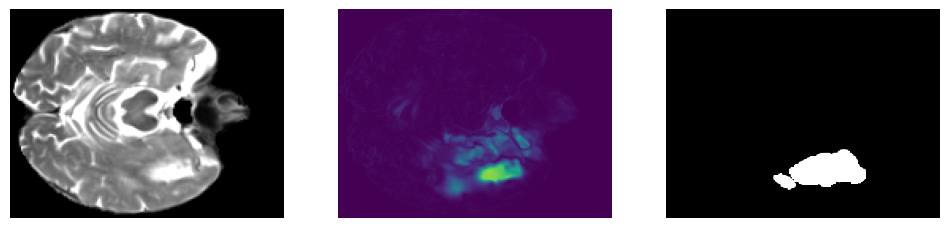

In [7]:
fig,ax = plt.subplots(1,3,figsize=(12,4))

ax[0].imshow(b['data'][i,0],'gray',vmin=0,vmax=1)
ax[1].imshow(anomaly_score[i,0],vmin=0,vmax=.1)
ax[2].imshow(b["seg"][i][0],'gray',vmin=0,vmax=.2,)
[a.axis('off') for a in ax]
i+=1